In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
import shutil

## Style sheet
plt.style.use("seaborn-v0_8-paper")
latex_installed = shutil.which("latex") is not None

rcparams = {
    "text.usetex": latex_installed,
    "font.size": 12,
    "lines.linewidth": 2,
    "mathtext.fontset": "cm", 
}

if latex_installed:
    rcparams["text.latex.preamble"] = r"\usepackage{amsmath}"
    rcparams["font.family"] = "cmu serif"
else:
    rcparams["font.family"] = "serif"

plt.rcParams.update(rcparams)

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

## Import data, setup 

In [13]:
from data.simulated_data.generate_simulated_data import generate_simulated_data
from src.algorithms import IMMCV, RGPMT_ND, MMRGP
from src.utils import sq_exp_kernel, matern_kernel

generate_simulated_data(meas_drop_rate=0.95, seed=22)
data = np.load("./data/simulated_data/data.npz")

time_steps = data["time"]
true_x = data["true_x"]
true_y = data["true_y"]
true_z = data["true_z"]
meas_x = data["meas_x"][0]
meas_y = data["meas_y"][0]
meas_z = data["meas_z"][0]
mask = data["mask"][0]

dim = 3
num_time_steps = len(time_steps)
num_measurements = np.sum(mask)
q_levels = np.array([1.0, 5.0, 10.0, 15.0, 20.0])
length_scales = np.array([1.0, 3.0, 5.0, 7.0, 9.0])
r = 0.5
num_models = len(q_levels)
num_states = 25
kernel = sq_exp_kernel
theta_init = np.array([25.0, 5.0, 0.5])

imm_cv = IMMCV(q_levels, r, time_steps[1] - time_steps[0], dim=dim)
if dim == 2:
    rgp_mt = RGPMT_ND(num_states, time_steps[0:num_states], [meas_x[0:num_states], meas_y[0:num_states]], kernel, theta_init=theta_init, dim=dim)
elif dim == 3:
    rgp_mt = RGPMT_ND(num_states, time_steps[0:num_states], [meas_x[0:num_states], meas_y[0:num_states], meas_z[0:num_states]], kernel, theta_init=theta_init, dim=dim)
mm_rgp = MMRGP(kernel, time_steps[-1], length_scales, r, num_states, 1e-3, 5.0, dim=dim)

print("Number of timesteps:", num_time_steps)
print("Number of observations:", num_measurements)

Number of timesteps: 1500
Number of observations: 69


## IMM-CV single run

IMM-CV total run time: 0.17 seconds for 1500 steps.
Average runtime for IMM-CV: 3.545699e-04 seconds


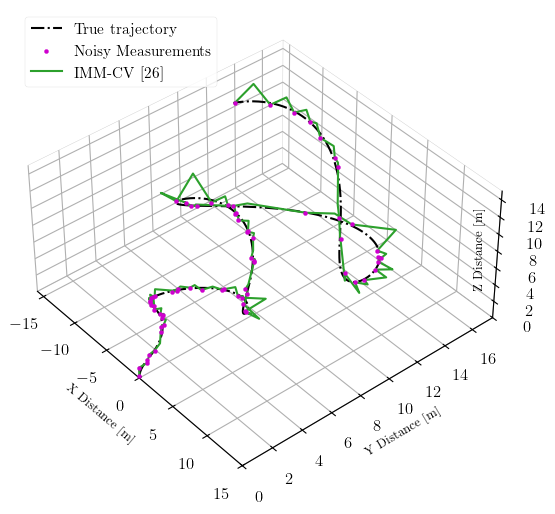

In [14]:
immcv_est_x = np.zeros(num_time_steps)
immcv_est_y = np.zeros(num_time_steps)
immcv_est_z = np.zeros(num_time_steps)
mode_probs = np.zeros((num_time_steps, num_models))

start = time.time()
time_list = []
for k in range(num_time_steps):
    if dim == 2:
        z = np.array([meas_x[k], meas_y[k]])
    elif dim == 3:
        z = np.array([meas_x[k], meas_y[k], meas_z[k]])
    start_time = time.time()
    imm_cv.predict()
    if not np.isnan(z).any():
        imm_cv.update(z)
        delta_time = time.time() - start_time
        # print("{:e}".format(delta_time))
        time_list.append(delta_time)

    # Save estimates
    immcv_est_x[k] = imm_cv.x[0][0]
    immcv_est_y[k] = imm_cv.x[2][0]
    if dim ==3:
        immcv_est_z[k] = imm_cv.x[4][0]
    mode_probs[k] = imm_cv.mu

print(f"IMM-CV total run time: {time.time() - start:.2f} seconds for {num_time_steps} steps.")

print("Average runtime for IMM-CV: {:e} seconds".format(np.mean(time_list)))

if dim == 2:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(true_x, true_y, "k-.", label="True trajectory")
    ax.plot(
        meas_x,
        meas_y,
        linestyle="",
        marker=".",
        color="red",
        label="Noisy Measurements",
        markersize=5,
    )
    ax.plot(immcv_est_x, immcv_est_y, label="IMM-CV", color=colors[2])
    ax.set_aspect("equal")
    ax.set_xlabel("Horizontal Distance [m]")
    ax.set_ylabel("Vertical Distance [m]")
    ax.legend()
    ax.set_ylim((0.0, 17.0))
    ax.set_xlim((-15.0, 15.0))
    ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig("./figures/simulation/imm_cv.pdf", format="pdf", bbox_inches="tight")
elif dim == 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(true_x, true_y, true_z, "k-.", label="True trajectory", linewidth=1.5)
    ax.scatter(
        meas_x, meas_y, meas_z,
        color="#CE00CE", s=35, marker=".", label="Noisy Measurements", depthshade=False
    )
    ax.plot(immcv_est_x, immcv_est_y, immcv_est_z, label="IMM-CV [26]", color=colors[2], linewidth=1.5)
    ax.set_xlabel("X Distance [m]")
    ax.set_ylabel("Y Distance [m]")
    
    xlab = ax.xaxis.get_label()
    ax.set_zlabel("")  # disable default

    ax.text2D(
        0.95, 0.5, "Z Distance [m]",
        transform=ax.transAxes,
        rotation=90,
        va="center",
        ha="left",
        fontsize=xlab.get_fontsize(),
        fontfamily=xlab.get_fontfamily(),
        fontstyle=xlab.get_fontstyle(),
        fontweight=xlab.get_fontweight(),
    )
       
    ax.set_xlim(-16.0, 15.0)
    ax.set_ylim(0.0, 17.5)
    ax.set_zlim(0.0, 15.0)
    ax.set_box_aspect([30, 30, 15])

    # Grid and styling
    ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], alpha=0.5)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('gray')
    ax.yaxis.pane.set_edgecolor('gray')
    ax.zaxis.pane.set_edgecolor('gray')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=11, loc="upper left", frameon=True)
    #ax.tick_params(axis='both', which='major', labelsize=12)
    ax.view_init(elev=40, azim=-40)
    plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8, wspace=0, hspace=0)
    plt.savefig("./figures/simulation/imm_cv.pdf", format="pdf", bbox_inches="tight") 

## RGPMT single run

RGP*MT total run time: 4.94 seconds for 1500 steps.
Average runtime for RGP*MT: 3.327411e-03 seconds.


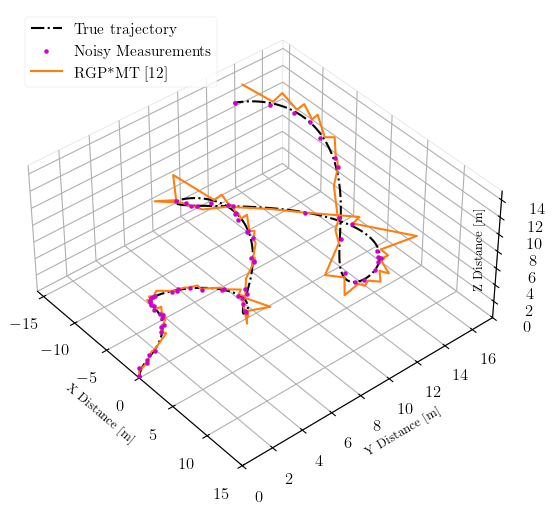

In [15]:
start = time.time()
time_list = []
for k in range(num_time_steps):
    if dim == 2:
        z = np.array([meas_x[k], meas_y[k]])
    elif dim == 3:
        z = np.array([meas_x[k], meas_y[k], meas_z[k]])
    start_time = time.time()
    meas_time = time_steps[k]
    rgp_mt.step(z, meas_time)
    if not np.isnan(z).any():
        delta_time = time.time() - start_time
        # print("{:e}".format(delta_time))
        time_list.append(delta_time)

print(f"RGP*MT total run time: {time.time() - start:.2f} seconds for {num_time_steps} steps.")

print("Average runtime for RGP*MT: {:e} seconds.".format(np.mean(time_list)))

est_traj = rgp_mt.predicted_mean()
rgpmt_est_x = est_traj[0]
rgpmt_est_y = est_traj[1]
if dim == 3:
    rgpmt_est_z = est_traj[2]

if dim == 2:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(true_x, true_y, "k-.", label="True trajectory")
    ax.plot(rgpmt_est_x, rgpmt_est_y, label="RGP*MT", color=colors[1])
    ax.plot(
        meas_x,
        meas_y,
        linestyle="",
        marker=".",
        color="red",
        label="Noisy Measurements",
        markersize=5,
    )
    ax.set_aspect("equal")
    ax.set_xlabel("Horizontal Distance [m]")
    ax.set_ylabel("Vertical Distance [m]")
    ax.legend()
    ax.set_ylim((0.0, 17.0))
    ax.set_xlim((-15.0, 15.0))
    ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig("./figures/simulation/rgpmt.pdf", format="pdf", bbox_inches="tight")
elif dim == 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(true_x, true_y, true_z, "k-.", label="True trajectory", linewidth=1.5)
    ax.scatter(
        meas_x, meas_y, meas_z,
        color="#CE00CE", s=35, marker=".", label="Noisy Measurements", depthshade=False
    )
    ax.plot(rgpmt_est_x, rgpmt_est_y, rgpmt_est_z, label="RGP*MT [12]", color=colors[1], linewidth=1.5)
    ax.set_xlabel("X Distance [m]")
    ax.set_ylabel("Y Distance [m]")
    
    xlab = ax.xaxis.get_label()
    ax.set_zlabel("")  # disable default

    ax.text2D(
        0.95, 0.5, "Z Distance [m]",
        transform=ax.transAxes,
        rotation=90,
        va="center",
        ha="left",
        fontsize=xlab.get_fontsize(),
        fontfamily=xlab.get_fontfamily(),
        fontstyle=xlab.get_fontstyle(),
        fontweight=xlab.get_fontweight(),
    )

    ax.set_xlim(-16.0, 15.0)
    ax.set_ylim(0.0, 17.5)
    ax.set_zlim(0.0, 15.0)
    ax.set_box_aspect([30, 30, 15])

    # Grid and styling
    ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], alpha=0.5)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('gray')
    ax.yaxis.pane.set_edgecolor('gray')
    ax.zaxis.pane.set_edgecolor('gray')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=11, loc="upper left", frameon=True)
    #ax.tick_params(axis='both', which='major', labelsize=12)
    ax.view_init(elev=40, azim=-40)
    plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8, wspace=0, hspace=0)
    plt.savefig("./figures/simulation/rgpmt.pdf", format="pdf", bbox_inches="tight") 

## MM-RGP single run

IMM-RGP total run time: 0.87 seconds for 1500 steps.
Average runtime for IMM-RGP: 1.275474e-03 seconds


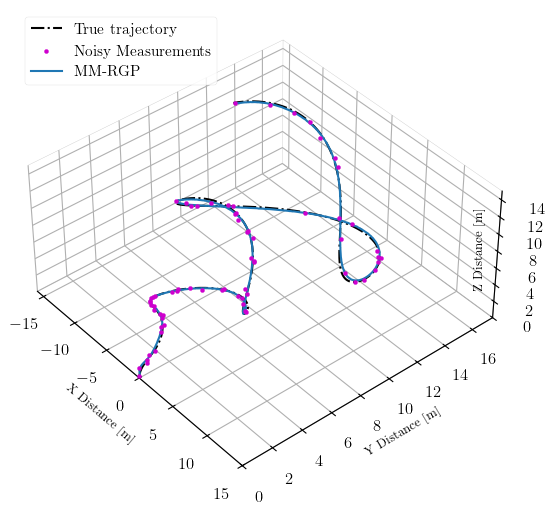

In [16]:
start = time.time()
time_list = []
for k in range(num_time_steps):
    if dim == 2:
        z = np.array([meas_x[k], meas_y[k]])
    elif dim == 3:
        z = np.array([meas_x[k], meas_y[k], meas_z[k]])
    start_time = time.time()
    meas_time = time_steps[k]
    mm_rgp.time_update()
    if not np.isnan(z).any():
        mm_rgp.meas_update(z, meas_time)
        delta_time = time.time() - start_time
        time_list.append(delta_time)

print(f"IMM-RGP total run time: {time.time() - start:.2f} seconds for {num_time_steps} steps.")

print("Average runtime for IMM-RGP: {:e} seconds".format(np.mean(time_list)))

est_traj = mm_rgp.predicted_mean(time_steps)
mmrgp_est_x = est_traj[0:num_time_steps]
mmrgp_est_y = est_traj[num_time_steps:2*num_time_steps]

if dim == 3:
    mmrgp_est_z = est_traj[2*num_time_steps:]

if dim == 2:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(true_x, true_y, "k-.", label="True trajectory")
    ax.plot(mmrgp_est_x, mmrgp_est_y, label="Proposed", color=colors[0])
    ax.plot(
        meas_x,
        meas_y,
        linestyle="",
        marker=".",
        color="red",
        label="Noisy Measurements",
        markersize=5,
    )
    ax.set_aspect("equal")
    ax.set_xlabel("Horizontal Distance [m]")
    ax.set_ylabel("Vertical Distance [m]")
    ax.legend()
    ax.set_ylim((0.0, 17.0))
    ax.set_xlim((-15.0, 15.0))
    ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig("./figures/simulation/mm_rgp.pdf", format="pdf", bbox_inches="tight")
elif dim == 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(true_x, true_y, true_z, "k-.", label="True trajectory", linewidth=1.5)
    ax.scatter(
        meas_x, meas_y, meas_z,
        color="#CE00CE", s=35, marker=".", label="Noisy Measurements", depthshade=False
    )
    ax.plot(mmrgp_est_x, mmrgp_est_y, mmrgp_est_z, label="MM-RGP", color=colors[0], linewidth=1.5)
    ax.set_xlabel("X Distance [m]")
    ax.set_ylabel("Y Distance [m]")
    
    xlab = ax.xaxis.get_label()
    ax.set_zlabel("")  # disable default

    ax.text2D(
        0.95, 0.5, "Z Distance [m]",
        transform=ax.transAxes,
        rotation=90,
        va="center",
        ha="left",
        fontsize=xlab.get_fontsize(),
        fontfamily=xlab.get_fontfamily(),
        fontstyle=xlab.get_fontstyle(),
        fontweight=xlab.get_fontweight(),
    )

    ax.set_xlim(-16.0, 15.0)
    ax.set_ylim(0.0, 17.5)
    ax.set_zlim(0.0, 15.0)
    ax.set_box_aspect([30, 30, 15])

    # Grid and styling
    ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], alpha=0.5)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('gray')
    ax.yaxis.pane.set_edgecolor('gray')
    ax.zaxis.pane.set_edgecolor('gray')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=11, loc="upper left", frameon=True)
    #ax.tick_params(axis='both', which='major', labelsize=12)
    ax.view_init(elev=40, azim=-40)
    plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8, wspace=0, hspace=0)
    plt.savefig("./figures/simulation/mm_rgp.pdf", format="pdf", bbox_inches="tight") 

## Combined figure

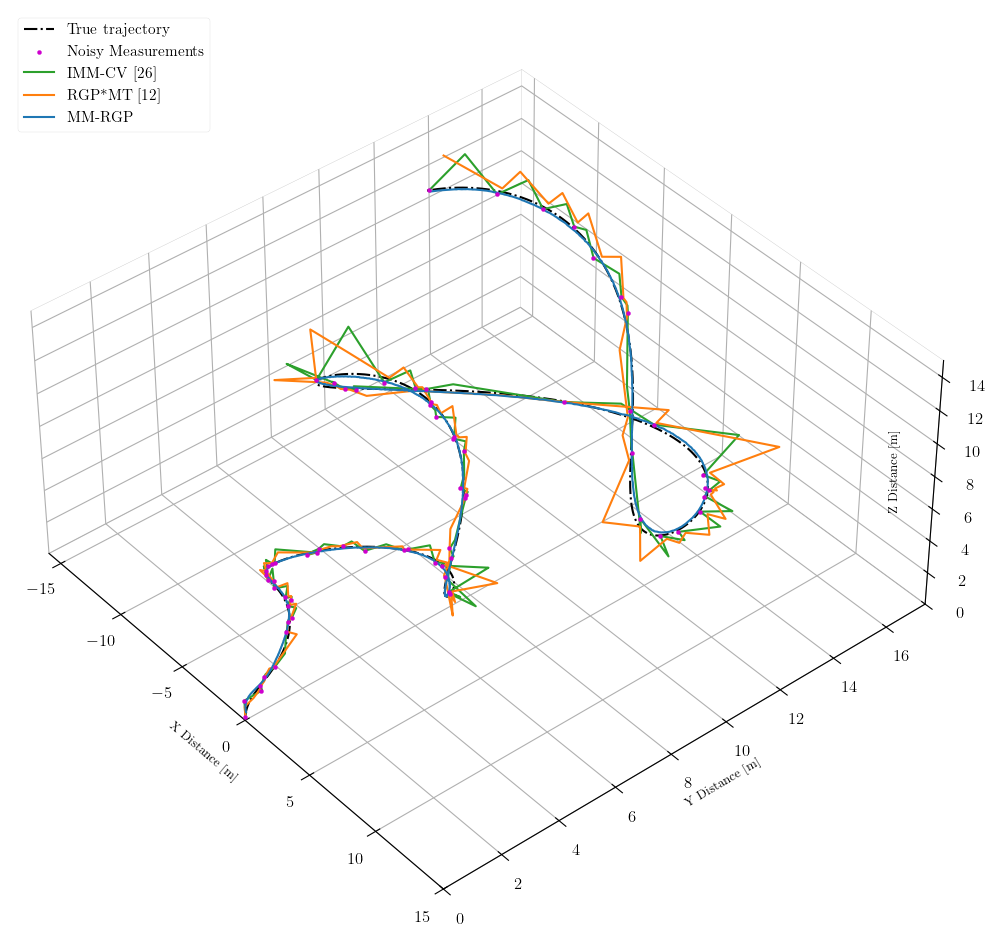

In [18]:

if dim == 2:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(true_x, true_y, "k-.", label="True trajectory")
    ax.plot(immcv_est_x, immcv_est_y, label="IMM-CV", color=colors[2])
    ax.plot(rgpmt_est_x, rgpmt_est_y, label="RGP*MT", color=colors[1])
    ax.plot(mmrgp_est_x, mmrgp_est_y, label="Proposed", color=colors[0])
    ax.plot(
        meas_x,
        meas_y,
        linestyle="",
        marker=".",
        color="red",
        label="Noisy Measurements",
        markersize=5,
    )
    ax.set_aspect("equal")
    ax.set_xlabel("Horizontal Distance [m]")
    ax.set_ylabel("Vertical Distance [m]")
    ax.legend()
    ax.set_ylim((0.0, 17.0))
    ax.set_xlim((-15.0, 15.0))
    ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig("./figures/simulation/mm_rgp.pdf", format="pdf", bbox_inches="tight")
elif dim == 3:
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(true_x, true_y, true_z, "k-.", label="True trajectory", linewidth=1.5)
    ax.scatter(
        meas_x, meas_y, meas_z,
        color="#CE00CE", s=35, marker=".", label="Noisy Measurements", depthshade=False
    )
    ax.plot(immcv_est_x, immcv_est_y, immcv_est_z, label="IMM-CV [26]", color=colors[2], linewidth=1.5)
    ax.plot(rgpmt_est_x, rgpmt_est_y, rgpmt_est_z, label="RGP*MT [12]", color=colors[1], linewidth=1.5)
    ax.plot(mmrgp_est_x, mmrgp_est_y, mmrgp_est_z, label="MM-RGP", color=colors[0], linewidth=1.5)
    ax.set_xlabel("X Distance [m]")
    ax.set_ylabel("Y Distance [m]")
    
    xlab = ax.xaxis.get_label()
    ax.set_zlabel("")  # disable default

    ax.text2D(
        0.95, 0.5, "Z Distance [m]",
        transform=ax.transAxes,
        rotation=90,
        va="center",
        ha="left",
        fontsize=xlab.get_fontsize(),
        fontfamily=xlab.get_fontfamily(),
        fontstyle=xlab.get_fontstyle(),
        fontweight=xlab.get_fontweight(),
    )

    ax.set_xlim(-16.0, 15.0)
    ax.set_ylim(0.0, 17.5)
    ax.set_zlim(0.0, 15.0)
    ax.set_box_aspect([30, 30, 15])

    # Grid and styling
    ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], alpha=0.5)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('gray')
    ax.yaxis.pane.set_edgecolor('gray')
    ax.zaxis.pane.set_edgecolor('gray')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=11, loc="upper left", frameon=True)
    #ax.tick_params(axis='both', which='major', labelsize=12)
    ax.view_init(elev=40, azim=-40)
    plt.savefig("./figures/simulation/combined_sim.pdf", format="pdf", bbox_inches="tight") 